Square-root version of parsmooth; but currently running the non-squareroot filtering.

In [1]:
%load_ext autoreload
%autoreload 2


### Imports

In [2]:
import numpy as np
from jax.config import config

#config.update("jax_enable_x64", True)

import parsmooth
from parsmooth import FunctionalModel, MVNSqrt, MVNStandard
from parsmooth.linearization import extended, cubature
from parsmooth.methods import iterated_smoothing, filter_smoother
from parsmooth.sequential._filtering import _standard_predict, _standard_update, _sqrt_predict, _sqrt_update
from parsmooth._utils import tria, qr as my_qr
from jax.scipy.linalg import cho_solve, solve_triangular

In [3]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import tornadox

## Initial Value Problem

In [12]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e2)
ylims = (-3, 3)
f = ivp.f
y0 = ivp.y0
t0, tmax = ivp.t0, ivp.tmax

## Definig the ODE Solver

In [13]:
# Fixed-step solver with step-size
dt = 1e-3

# Solver order
order = 2

### 1. Prior
Build the transition matrices (using `tornadox` because I'm lazy)

In [14]:
d, q = len(y0), order
D = d * (q+1)
diffusion = 1

iwp = tornadox.iwp.IntegratedWienerTransition(
    num_derivatives=q, wiener_process_dimension=d)
P, PI = iwp.nordsieck_preconditioner(dt)
E0 = iwp.projection_matrix(0) @ P
E1 = iwp.projection_matrix(1) @ P
A, QS = iwp.preconditioned_discretize
Q = (QS @ QS.T)

@jax.jit
def tf(x, A):
    return A @ x

transition_function = jax.jit(partial(tf, A=A))

b = jnp.zeros(D)
transition_model = FunctionalModel(transition_function, MVNSqrt(b, QS))
#transition_model = FunctionalModel(transition_function, MVNStandard(b, Q))

### 2. Observation Model

In [15]:
def of(x, f, E0, E1):
    return E1@x - f(None, E0@x)

observation_function = jax.jit(partial(of, f=f, E0=E0, E1=E1))

c = jnp.zeros(d)
RS = 0 * jnp.eye(d)
observation_model = FunctionalModel(observation_function, MVNSqrt(c, RS))
#observation_model = FunctionalModel(observation_function, MVNStandard(c, RS))

### 3. Data
We want the ODE to be satisfied == we want the difference to be zero == zero data:

In [16]:
ts = jnp.arange(t0, tmax+dt, dt)
data = jnp.zeros((len(ts)-1, d))
print(data.shape)

(6300, 2)


## 4. Initial state
Again computed with `tornadox`:

In [17]:
m0, P0 = tornadox.init.TaylorMode()(
    f=f, df=None, y0=y0, t0=0, num_derivatives=q)
m0, P0 = jnp.concatenate(m0.T), jnp.kron(jnp.eye(d), P0)
m0, P0 = PI @ m0, PI @ P0 @ PI
x0 = MVNSqrt(m0, P0)
#x0 = MVNStandard(m0, P0)

In [18]:
observation_model.function(m0)

DeviceArray([0.00000000e+00, 2.84217094e-14], dtype=float64)

## Solve the ODE with `parsmooth`

(-3.0, 3.0)

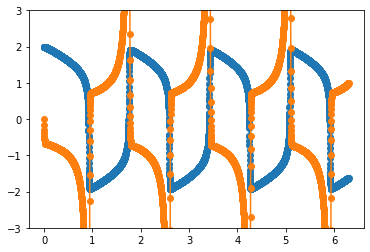

In [19]:
ekf_res = parsmooth.sequential._filtering.filtering(
    data, 
    x0, 
    transition_model, 
    observation_model, 
    extended,                               
    None,
)
plt.plot(ts, jnp.dot(E0, ekf_res.mean.T).T, marker="o")
plt.ylim(ylims)